In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label

# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML


# Load Data

In [195]:
# Loading + training,validation test split
far = glob.glob('./vehicles/GTI_Far/*.png')
close = glob.glob('./vehicles/GTI_MiddleClose/*.png')
left = glob.glob('./vehicles/GTI_Left/*.png')
right = glob.glob('./vehicles/GTI_Right/*.png')
kitti = glob.glob('./vehicles/KITTI_extracted/*.png')

not_vehicles = glob.glob('./non-vehicles/Extras/*.png') + glob.glob('./non-vehicles/GTI/*.png')

In [196]:
# do a split of 70,20,10 for train,valid and test set

len_list_1 = (0.7 * np.array([len(far), len(close), len(left), len(right)])).astype('int')
len_list_2 = (0.9 * np.array([len(far), len(close), len(left), len(right)])).astype('int')

y_kitti = np.ones(len(kitti), dtype=np.uint8)

X_kitti_train, X_kitti_rest, y_kitti_train, y_kitti_rest = train_test_split(kitti, y_kitti, test_size=0.30, random_state=40)
print(len(X_kitti_train))

X_kitti_valid, X_kitti_test, y_kitti_valid, y_kitti_test = train_test_split(X_kitti_rest, y_kitti_rest, test_size=0.33, random_state=40)
print(len(X_kitti_valid))
print(len(X_kitti_test))

y_notvehicles = np.zeros(len(not_vehicles), dtype=np.uint8)
X_notvehicles_train, X_notvehicles_rest, y_notvehicles_train, y_notvehicles_rest = train_test_split(not_vehicles, y_notvehicles, test_size=0.30, random_state=40)
print(len(X_notvehicles_train))

X_notvehicles_valid, X_notvehicles_test, y_notvehicles_valid, y_notvehicles_test = train_test_split(X_notvehicles_rest, y_notvehicles_rest, test_size=0.33, random_state=40)

vehicles_train_set = far[:len_list_1[0]] + close[:len_list_1[1]] + left[:len_list_1[2]] + right[:len_list_1[3]] + X_kitti_train
notvehicles_train_set = X_notvehicles_train

vehicles_valid_set = far[len_list_1[0]:len_list_2[0]] + close[len_list_1[1]:len_list_2[1]] + left[len_list_1[2]:len_list_2[2]] + right[len_list_1[3]:len_list_2[3]] + X_kitti_valid
notvehicles_valid_set = X_notvehicles_valid

vehicles_test_set = far[len_list_2[0]:] + close[len_list_2[1]:] + left[len_list_2[2]:] + right[len_list_2[3]:] + X_kitti_test
notvehicles_test_set = X_notvehicles_test

4176
1199
591
6277


In [197]:
print(len(vehicles_train_set))
print(len(notvehicles_train_set))
print(len(vehicles_valid_set))
print(len(notvehicles_valid_set))
print(len(vehicles_test_set))
print(len(notvehicles_test_set))


6152
6277
1765
1802
875
889


In [ ]:
# Save the data regarding samples
pickle_file = 'data.p'
try:
    with open(pickle_file, 'wb') as pfile:
        pickle.dump(
            {
                'vehicles_train_set': vehicles_train_set,
                'notvehicles_train_set': notvehicles_train_set,
                'vehicles_valid_set': vehicles_valid_set,
                'notvehicles_valid_set': notvehicles_valid_set,
                'vehicles_test_set': vehicles_test_set,
                'notvehicles_test_set': notvehicles_test_set
            },
            pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise


# Explore data

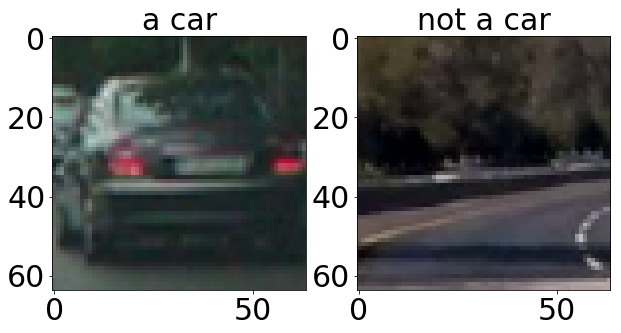

In [201]:
#load data
data_file = 'data.p'
with open(data_file, mode='rb') as f:
    data = pickle.load(f)
vehicles_train_set = data['vehicles_train_set']
notvehicles_train_set = data['notvehicles_train_set']
vehicles_valid_set = data['vehicles_valid_set']
notvehicles_valid_set = data['notvehicles_valid_set']
vehicles_test_set = data['vehicles_test_set']
notvehicles_test_set = data['notvehicles_test_set']

i=88
a_car = plt.imread(vehicles_train_set[i])
not_a_car = plt.imread(notvehicles_train_set[i])
vehicles_train_set[i],notvehicles_train_set[i]

font_size=30
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(a_car)
ax1.set_title('a car', fontsize=font_size)
ax2.imshow(not_a_car)
ax2.set_title('not a car', fontsize=font_size)
plt.rc('xtick', labelsize=font_size) 
plt.rc('ytick', labelsize=font_size) 
plt.savefig('output_images/carvsnot.jpg')
plt.show()

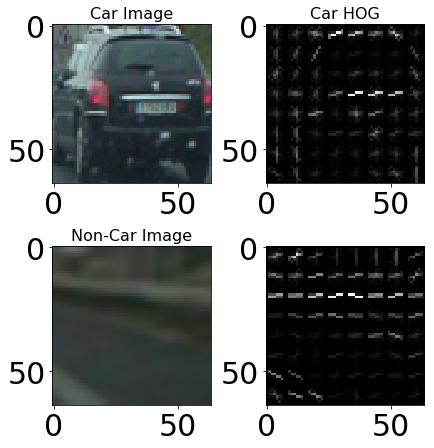

In [226]:
car_img = mpimg.imread(vehicles_train_set[5])
_, car_dst = get_hog_features(car_img[:,:,2], orient, pix_per_cell, cell_per_block, 
                                        vis=True, feature_vec=True)
noncar_img = mpimg.imread(notvehicles_train_set[5])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], orient, pix_per_cell, cell_per_block, 
                                        vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
plt.savefig('output_images/hog.jpg')
plt.show()

# Prepare features

In [227]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


def get_features_from_image_set(image_set):
    ### TODO: Tweak these parameters and see how the results change.
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off

    features = extract_features(image_set, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    return features

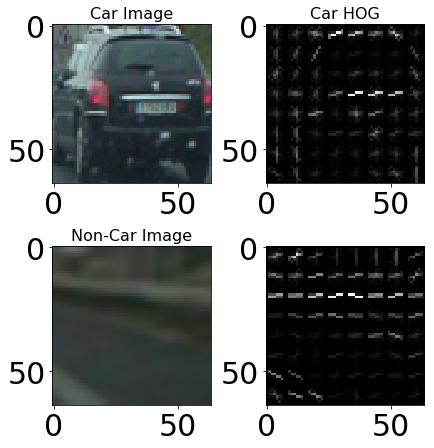

In [210]:
car_img = mpimg.imread(vehicles_train_set[5])
_, car_dst = get_hog_features(car_img[:,:,2], orient, pix_per_cell, cell_per_block, 
                                        vis=True, feature_vec=True)
noncar_img = mpimg.imread(notvehicles_train_set[5])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], orient, pix_per_cell, cell_per_block, 
                                        vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
plt.savefig('output_images/hog.jpg')
plt.show()

In [230]:
image_sets = [vehicles_train_set, notvehicles_train_set, vehicles_valid_set, notvehicles_valid_set, vehicles_test_set, notvehicles_test_set]
names = ['vehicles_train_set', 'notvehicles_train_set', 'vehicles_valid_set', 'notvehicles_valid_set', 'vehicles_test_set', 'notvehicles_test_set']
feature_list = [[], [], [], [], [], []]

for index, image_set in enumerate(image_sets):
    t=time.time()
    feature_list[index] = get_features_from_image_set(image_sets[index])
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract {0}'.format(names[index]))
    
vehicles_train_set_features = feature_list[0]
notvehicles_train_set_features  = feature_list[1]
vehicles_valid_set_features  = feature_list[2]
notvehicles_valid_set_features  = feature_list[3]
vehicles_test_set_features  = feature_list[4]
notvehicles_test_set_features  = feature_list[5]

42.82 Seconds to extract vehicles_train_set
44.12 Seconds to extract notvehicles_train_set
12.98 Seconds to extract vehicles_valid_set
13.1 Seconds to extract notvehicles_valid_set
6.44 Seconds to extract vehicles_test_set
6.35 Seconds to extract notvehicles_test_set


In [ ]:
image_sets = [vehicles_train_set[:len(vehicles_train_set)//10], notvehicles_train_set[:len(notvehicles_train_set)//10], vehicles_valid_set[:len(vehicles_valid_set)//10], notvehicles_valid_set[:len(notvehicles_valid_set)//10], vehicles_test_set[:len(vehicles_test_set)//10], notvehicles_test_set[:len(notvehicles_test_set)//10]]
names = ['vehicles_train_set', 'notvehicles_train_set', 'vehicles_valid_set', 'notvehicles_valid_set', 'vehicles_test_set', 'notvehicles_test_set']
feature_list = [[], [], [], [], [], []]

for index, image_set in enumerate(image_sets):
    t=time.time()
    feature_list[index] = get_features_from_image_set(image_sets[index])
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract {0}'.format(names[index]))

vehicles_train_set_features = feature_list[0]
notvehicles_train_set_features  = feature_list[1]
vehicles_valid_set_features  = feature_list[2]
notvehicles_valid_set_features  = feature_list[3]
vehicles_test_set_features  = feature_list[4]
notvehicles_test_set_features  = feature_list[5]

In [231]:
vehicles_train_set_features = feature_list[0]
notvehicles_train_set_features  = feature_list[1]
vehicles_valid_set_features  = feature_list[2]
notvehicles_valid_set_features  = feature_list[3]
vehicles_test_set_features  = feature_list[4]
notvehicles_test_set_features  = feature_list[5]

print(len(vehicles_train_set_features ))
print(len(notvehicles_train_set_features ))
print(len(vehicles_valid_set_features ))
print(len(notvehicles_valid_set_features ))
print(len(vehicles_test_set_features ))
print(len(notvehicles_test_set_features ))

print(vehicles_train_set_features[0].shape)

6152
6277
1765
1802
875
889
(8460,)


In [232]:
# Pool every feature set together so we only call the scaler once
X = np.vstack((vehicles_train_set_features,
               notvehicles_train_set_features,
               vehicles_valid_set_features,
               notvehicles_valid_set_features,
               vehicles_test_set_features,
               notvehicles_test_set_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

In [233]:
index_1 = len(vehicles_train_set_features)
index_2 = index_1 + len(notvehicles_train_set_features)
index_3 = index_2 + len(vehicles_valid_set_features)
index_4 = index_3 + len(notvehicles_valid_set_features)
index_5 = index_4 + len(vehicles_test_set_features)

vehicles_train_set_features = scaled_X[:index_1]
notvehicles_train_set_features = scaled_X[index_1:index_2]
vehicles_valid_set_features = scaled_X[index_2:index_3]
notvehicles_valid_set_features = scaled_X[index_3:index_4]
vehicles_test_set_features = scaled_X[index_4:index_5]
notvehicles_test_set_features = scaled_X[index_5:]

#y_train = np.hstack((np.ones(len(vehicles_train_set_features)), np.zeros(len(notvehicles_train_set_features))))
y_train = np.hstack((np.ones(len(vehicles_train_set_features)), np.zeros(len(notvehicles_train_set_features)), np.ones(len(vehicles_valid_set_features)), np.zeros(len(notvehicles_valid_set_features))))
#y_val = np.hstack((np.ones(len(vehicles_valid_set_features)), np.zeros(len(notvehicles_valid_set_features))))
y_test = np.hstack((np.ones(len(vehicles_test_set_features)), np.zeros(len(notvehicles_test_set_features))))

#X_train = np.vstack((scaled_X[:index_1],scaled_X[index_1:index_2]))
X_train = np.vstack((scaled_X[:index_1],scaled_X[index_1:index_2],scaled_X[index_2:index_3],scaled_X[index_3:index_4]))
#X_val = np.vstack((scaled_X[index_2:index_3],scaled_X[index_3:index_4]))
X_test = np.vstack((scaled_X[index_4:index_5],scaled_X[index_5:]))

rand_state = np.random.randint(0, 100)

X_train,y_train = shuffle(X_train,y_train, random_state=rand_state)
#X_val,y_val = shuffle(X_val,y_val,random_state=42)
X_test,y_test = shuffle(X_test,y_test, random_state=rand_state)

# Train SVM

In [234]:
# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Training Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
#print('Validation Accuracy of SVC = ', round(svc.score(X_val, y_val), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

27.33 Seconds to train SVC...
Training Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9887


In [2]:
data = {
        'scaler': X_scaler,
        'classifier': svc
        }

with open('classifier.p', 'wb') as f:
    pickle.dump(data, f)

NameError: name 'X_scaler' is not defined

In [3]:
# Load the classifier and parameters
data_file = 'classifier.p'
with open(data_file, mode='rb') as f:
    data = pickle.load(f)
    
svc = data['classifier'] 
X_scaler = data['scaler']

In [4]:
images = sorted(glob.glob('test_images/*.jpg'))


# Slide Windows functions

In [212]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, viz):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    #detect from left lane field of view
    xstart = img.shape[1] // 3
    xstop = img.shape[1]
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxes = [] # rectangle defined by opposite points((x1, y1), (x2, y2))
#     print(nxsteps)
#     print(nysteps)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or viz is True:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                boxes.append(((xbox_left + xstart, ytop_draw + ystart), (xbox_left + win_draw + xstart, ytop_draw + win_draw + ystart)))
                
    return draw_img, boxes

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def predict_heatmap(image, bbox_list, threshold=1):
    heat = np.zeros_like(image[:, :, 0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, bbox_list)
            
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)
        
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
              
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


def predict_label(image, heatmap):
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return draw_img


# Single image tests

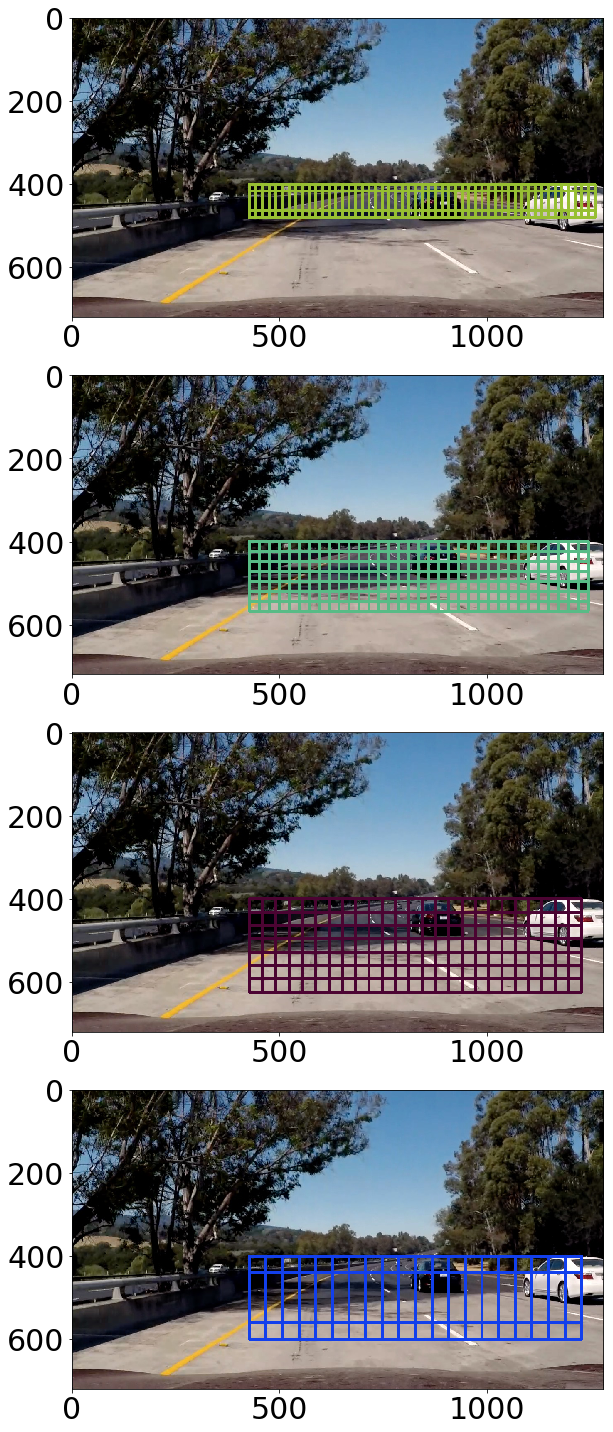

In [279]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

ystart = 400
ystop = 656

ystart_list = [400, 400, 400, 400]
#ystop_list = [656, 656, 656, 656]
ystop_list = [500, 596, 656, 656]
scales = [1.0, 1.5, 2.0, 2.5]

# ystart_list = [400, 400, 400]
# ystop_list = [656, 656, 656]
# scales = [1, 1.5, 2.0]

f, axis = plt.subplots(len(scales),1, figsize=(40,20))
f.tight_layout()

image = mpimg.imread(images[4])
#print(image.shape)
boxes_all = []

for index_scale, scale in enumerate(scales):
    final_image = np.copy(image)
    out_img, boxes = find_cars(final_image, ystart_list[index_scale], ystop_list[index_scale], scale, svc, X_scaler, orient, pix_per_cell, 
                                cell_per_block, spatial_size, hist_bins, True)
    boxes_all.extend(boxes)
    color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
    for box in boxes:
        cv2.rectangle(final_image, (box[0][0], box[0][1]), (box[1][0], box[1][1]), color, 6) 
    axis[index_scale].imshow(final_image)
    
plt.savefig('output_images/windows_scales.jpg')
plt.show()

(720, 1280, 3)


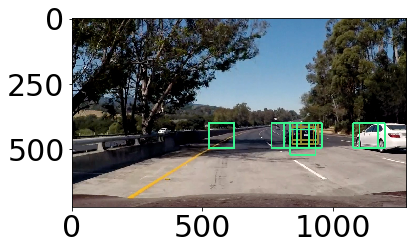

In [278]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

ystart = 400
ystop = 656

ystart_list = [400, 400, 430, 400]
ystop_list = [500, 596, 656, 656]
scales = [1.0, 1.5, 2.0, 2.5]

# ystart_list = [400, 400, 400]
# ystop_list = [656, 656, 656]
# scales = [1, 1.5, 2.0]

image = mpimg.imread(images[4])
print(image.shape)
boxes_all = []
final_image = np.copy(image)
for index_scale, scale in enumerate(scales):
    out_img, boxes = find_cars(image, ystart_list[index_scale], ystop_list[index_scale], scale, svc, X_scaler, orient, pix_per_cell, 
                                cell_per_block, spatial_size, hist_bins, False)
    boxes_all.extend(boxes)
    color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
    for box in boxes:
        cv2.rectangle(final_image, (box[0][0], box[0][1]), (box[1][0], box[1][1]), color, 6) 
        
plt.figure()
plt.imshow(final_image)
plt.savefig('./output_images/windows.jpg')
plt.show()

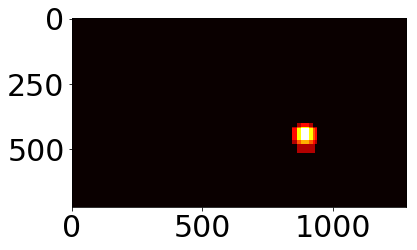

In [273]:
plt.figure()
heatmap = predict_heatmap(image, boxes_all,1)
plt.imshow(heatmap, cmap='hot')
plt.savefig('./output_images/heatmap.jpg')
plt.show()

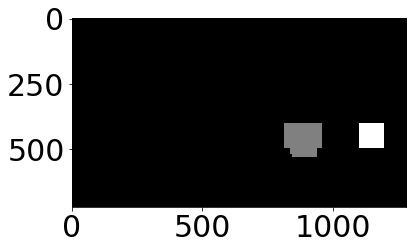

In [224]:
plt.figure()
labels = label(heatmap)
plt.imshow(labels[0], cmap='gray')
plt.savefig('./output_images/labels.jpg')
plt.show()

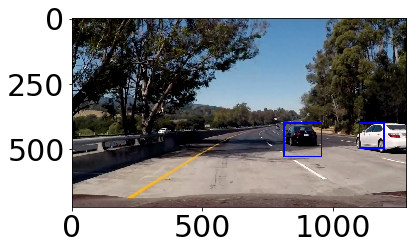

In [225]:
plt.figure()
final_img = predict_label(image, heatmap)
plt.imshow(final_img)
plt.savefig('./output_images/final.jpg')
plt.show()

# Video pipeline

In [228]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

def process_frame(frame, car_detector, ystart, ystop, scales, svc, X_scaler,orient, pix_per_cell, cell_per_block, 
                  spatial_size, hist_bins):
    
    frame_copy = np.copy(frame)
    
    img = car_detector.process_frame(frame_copy)

    return img

class CarDetector:
    def __init__(self):
        self.frames_to_smooth = 5 # num of frames we smooth over
        self.heatmaps = [] # heatmaps from previous frames we use for smoothing
        self.smooth_heatmeap = np.zeros((720, 1280)).astype(np.float64) # smoothed_heatmap
            
    def process_frame(self, frame):
        ystart_list = [400, 400, 400, 400]
        ystop_list = [656, 656, 656, 656]
        scales = [1, 1.5, 2.0]
        frame_copy = np.copy(frame)
        
        boxes_all = []
        for index_scale, scale in enumerate(scales):
            out_img, boxes = find_cars(frame_copy, ystart_list[index_scale], ystop_list[index_scale], scale, svc, X_scaler, orient, pix_per_cell, 
                                cell_per_block, spatial_size, hist_bins, False)
            boxes_all.extend(boxes)
        final_image = np.copy(frame_copy)
        heatmap = predict_heatmap(frame, boxes_all, 2)
        
        # keep frame heatmap for smoothing future frames
        self.heatmaps.append(heatmap)
        self.smooth_heatmeap = self.smooth_heatmeap + heatmap
        if len(self.heatmaps) > self.frames_to_smooth:
            self.smooth_heatmeap = self.smooth_heatmeap - self.heatmaps.pop(0)
            self.smooth_heatmeap = np.clip(self.smooth_heatmeap, 0.0, 10000000)      
        
        final_img = predict_label(final_image, self.smooth_heatmeap)
        
        return final_img
 
        

In [229]:
car_detector = CarDetector()

video_output = './result.mp4'
#clip1 = VideoFileClip("project_video.mp4").subclip(20,25)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(lambda frame: process_frame(frame, car_detector, ystart, ystop, scales, svc, X_scaler, 
                                                        orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./result.mp4
[MoviePy] Writing video ./result.mp4



100%|█████████▉| 1260/1261 [26:24<00:01,  1.23s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./result.mp4 



In [184]:
import io
import base64
from IPython.display import HTML

video = io.open('result.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" width="960" height="540" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
